# NS4 – Hand  and Skeleton  Pose Estimation


## Overview
This notebook is structured as follows:

1. Hand Detection  
    1.1 Mediapipe Hand Detection Pipeline  
    1.2 Mediapipe Hand Detection  
2. Skeleton Detection  
    2.1 Mediapipe Skeleton Detection  
    2.2 How Can We Get Joints From an Image?  
    2.3 Let's Try to Make Mediapipe Pose Work
3. Multiview Camera Calibration   
    3.1 MANO Hand Model  
    3.2 Interactive Demo

## 1 Hand Detection

Hand detection is an important pre-processing procedure for many human-hand related computer vision tasks, such as hand pose estimation, hand gesture recognition and human activity analysis.

### 1.1 Mediapipe Hand Detection Pipeline

#### 1.1.1 Palm Detection Model

The first step of Mediapipe hand detection is processing an image by a **Single Shot MultiBox Detector** ([SSD](https://arxiv.org/pdf/1512.02325.pdf)), and extracting the bounding box of the hands.

You can consider **hand detection** as a special case of object detection.

<br>

<figure style="text-align:center">
<img src="assets/hand_ssd.PNG" width="640" height="480" />
<figcaption >  </figcaption>
</figure>

Instead of training a hand detector, Mediapipe first trains a **palm detector** to localize the hand position. As palms are smaller objects, the non-maximum suppression algorithm works well in two-hand self-occlusion cases like handshakes. The finger detection is significantly harder than estimating bounding boxes of rigid objects like palms.



<figure style="text-alin:center">
<img src="assets/palm_detector.PNG" width="640" height="480" />
<figcaption >  </figcaption>
</figure>


#### 1.1.2 Hand landmark detection

After the palm detection over the whole image, the subsequent hand landmark model performs precise keypoint localization of 21 3D hand-knuckle coordinates inside the detected hand regions via regression, that is direct coordinate prediction. The model learns a consistent internal hand pose representation and is robust even to partially visible hands and self-occlusions.


<figure style="text-alin:center">
<img src="assets/hand_landmark.PNG" width="800" height="600" />
<figcaption >  </figcaption>
</figure>




### 1.2 Mediapipe Hand Detection
- Run it for static image
- Run it for real time video

In [1]:
###### First, install the mediapipe package

!pip install mediapipe

You should consider upgrading via the '/home/marsil/git/notebooks/venv/bin/python3 -m pip install --upgrade pip' command.


**Tips: All MediaPipe Solutions Python API examples are under mp.solutions.**

For the MediaPipe Hands solution, we can access this module as `mp_hands = mp.solutions.hands`.

You may change the parameters, such as 
- `static_image_mode`
- `max_num_hands`
- `min_detection_confidence`

during the initialization. Run `help(mp_hands.Hands)` to get more informations about the parameters.

#### 1.2.1 Let's try to make Mediapipe work now

In [2]:
# import related package and initialize Mediapipe hand

import cv2
import chumpy as ch
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
import torch
%matplotlib inline
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles

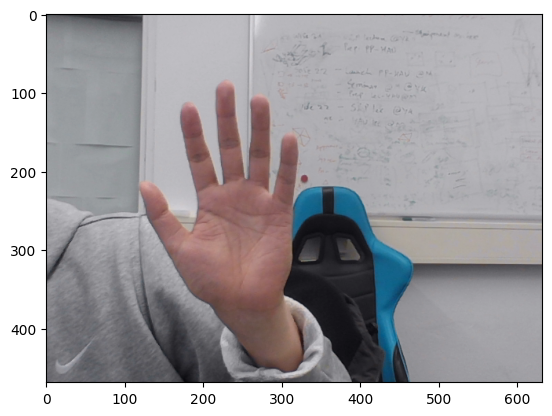

In [3]:
# show the demo picture

demo_pic = 'assets/hand_demo_rgb.png'
hand_img = cv2.imread(demo_pic)
hand_img = cv2.cvtColor(hand_img, cv2.COLOR_BGR2RGB)
plt.imshow(hand_img)

Handedness: [classification {
  index: 1
  score: 0.9827647805213928
  label: "Right"
}
]
hand_landmarks: landmark {
  x: 0.4021536707878113
  y: 0.7841596603393555
  z: 4.025692419418192e-07
}
landmark {
  x: 0.3191317915916443
  y: 0.7367874979972839
  z: -0.0323803536593914
}
landmark {
  x: 0.26723650097846985
  y: 0.6379963755607605
  z: -0.04263254627585411
}
landmark {
  x: 0.2354191392660141
  y: 0.5533091425895691
  z: -0.0506984144449234
}
landmark {
  x: 0.2070276439189911
  y: 0.48390308022499084
  z: -0.05751958116889
}
landmark {
  x: 0.33556079864501953
  y: 0.5054303407669067
  z: -0.006174102891236544
}
landmark {
  x: 0.3122055232524872
  y: 0.3985515534877777
  z: -0.02535044401884079
}
landmark {
  x: 0.2979833483695984
  y: 0.33089083433151245
  z: -0.04601706564426422
}
landmark {
  x: 0.2881051301956177
  y: 0.2692532539367676
  z: -0.06299438327550888
}
landmark {
  x: 0.3842753767967224
  y: 0.49016255140304565
  z: -0.009401042945683002
}
landmark {
  x: 0.371

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


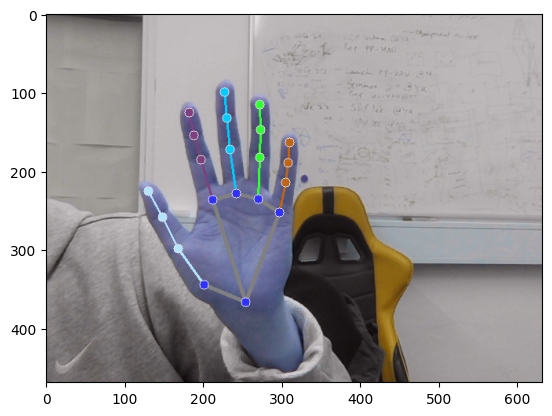

In [4]:
# Run Mediapipe hand detection for a single image

IMAGE_FILES = ['assets/hand_demo_rgb.png']

with mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5) as hands:
    
  for idx, file in enumerate(IMAGE_FILES):
    # Read an image, flip it around y-axis for correct handedness output (see
    # above).
    image = cv2.imread(file)
    # image = cv2.flip(cv2.imread(file), 1) , flip image for mirroring
   
    # Convert the BGR image to RGB before processing.
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Print handedness and draw hand landmarks on the image.
    print('Handedness:', results.multi_handedness)
    if not results.multi_hand_landmarks:
      continue
    image_height, image_width, _ = image.shape
    annotated_image = image.copy()
    for hand_landmarks in results.multi_hand_landmarks:
      print('hand_landmarks:', hand_landmarks)
      print(
          f'Index finger tip coordinates: (',
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].x * image_width}, '
          f'{hand_landmarks.landmark[mp_hands.HandLandmark.INDEX_FINGER_TIP].y * image_height})'
      )
      mp_drawing.draw_landmarks(
          annotated_image,
          hand_landmarks,
          mp_hands.HAND_CONNECTIONS,
          mp_drawing_styles.get_default_hand_landmarks_style(),
          mp_drawing_styles.get_default_hand_connections_style())
  
plt.imshow(annotated_image)

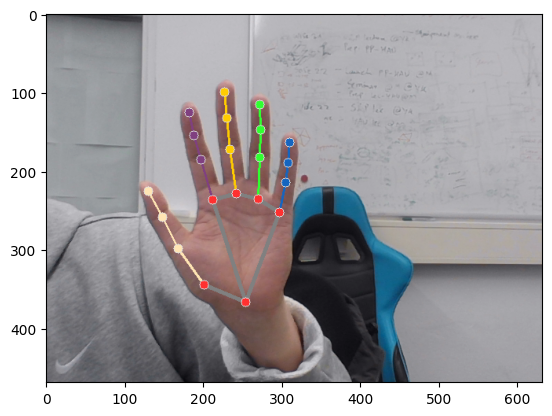

In [5]:
# make original color
mediapipe_hand_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.imshow(mediapipe_hand_image)

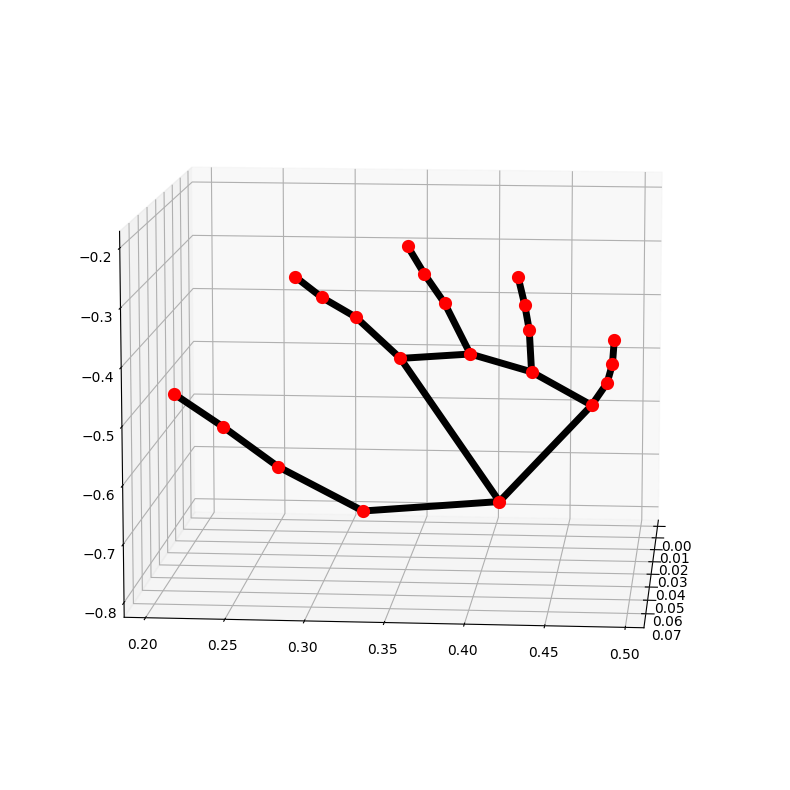

In [6]:
# Plot 3D hand detection 

with mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=2,
        min_detection_confidence=0.7) as hands:
    # for name, image in images.items():
        # Convert the BGR image to RGB and process it with MediaPipe Hands.
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    # for hand_world_landmarks in results.multi_hand_world_landmarks:
    for hand_world_landmarks in results.multi_hand_landmarks:
        mp_drawing.plot_landmarks(
            hand_world_landmarks, mp_hands.HAND_CONNECTIONS, azimuth=5)

In [8]:
# RUn Mediapipe hands for video and online camera

# For webcam input:
cap = cv2.VideoCapture(0)

with mp_hands.Hands(
    # model_complexity=0,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as hands:

  while cap.isOpened():
    success, image = cap.read()
    if not success:
      print("Ignoring empty camera frame.")
      # If loading a video, use 'break' instead of 'continue'.
      continue

    # To improve performance, optionally mark the image as not writeable to
    # pass by reference.
    image.flags.writeable = False
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image)

    # Draw the hand annotations on the image.
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    if results.multi_hand_landmarks:
      for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(
            image,
            hand_landmarks,
            mp_hands.HAND_CONNECTIONS,
            mp_drawing_styles.get_default_hand_landmarks_style(),
            mp_drawing_styles.get_default_hand_connections_style())
    # Flip the image horizontally for a selfie-view display.
    cv2.imshow('MediaPipe Hands', cv2.flip(image, 1))
    
    if cv2.waitKey(5) & 0xFF == ord("q"):
        break
    
cap.release()
cv2.destroyAllWindows()

## 2 Skeleton Detection

The skeleton detection aims to detect and locate key points of the human body, such as shoulder, elbow, knee and foot.

### 2.1 Mediapipe Skeleton Detection

#### 2.1.1 Mediapipe Pose

MediaPipe Pose is a ML solution for high-fidelity body pose tracking, inferring 33 3D landmarks and background segmentation mask on the whole body from RGB video frames utilizing the **BlazePose** research that also powers the ML Kit Pose Detection API. Current state-of-the-art approaches rely primarily on powerful desktop environments for inference, whereas Mediapipe achieves real-time performance on most modern mobile phones, desktops/laptops, in python and even on the web.

- BlazePose: https://ai.googleblog.com/2020/08/on-device-real-time-body-pose-tracking.html


Pose Landmark Model (BlazePose GHUM 3D)
The landmark model in MediaPipe Pose predicts the location of 33 pose landmarks (see figure below).


<figure style="text-alin:center">
<img src="assets/mediapipe_BlazePose.png" />
<figcaption >  </figcaption>
</figure>

Source: https://google.github.io/mediapipe/solutions/pose.html

### 2.2 How Can We Get Joints From an Image?

**A detection-followed-by-regression convolutional neural network**

The contribution of work is a convolutional neural network cascaded architecture specifically designed for learning part relationships and spatial context, and robustly inferring pose even for the case of severe part occlusions.

- The first part of our cascade outputs part detection heatmaps.
- The second part performs regression on these heatmaps. 

<figure style="text-alin:center">
<img src="assets/heatmap_skeleton.png" />
</figure>


### 2.3 Let's Try to Make Mediapipe Pose Work

In [9]:
# import related package and initialize Mediapipe pose

import cv2
import numpy as np
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_pose = mp.solutions.pose

In [10]:
# download pretrained weights for mediapipe
# copy it to '/usr/local/lib/python3.8/dist-packages/mediapipe/modules/pose_landmark'
!wget https://github.com/google/mediapipe/raw/master/mediapipe/modules/pose_landmark/pose_landmark_heavy.tflite

--2023-05-31 13:09:39--  https://github.com/google/mediapipe/raw/master/mediapipe/modules/pose_landmark/pose_landmark_heavy.tflite
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-05-31 13:09:39 ERROR 404: Not Found.



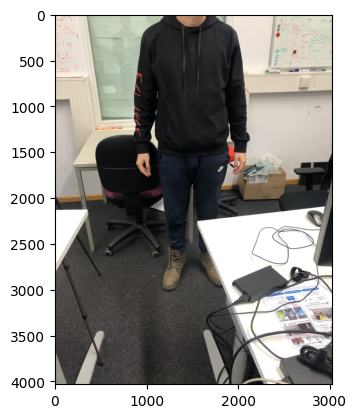

In [11]:
# Run Mediapipe skeleton detection for a single image
# Plot a single image
import matplotlib.pyplot as plt

IMAGE_FILES = ['assets/sekelton_pose.jpg']
test_img = cv2.imread(IMAGE_FILES[0])
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

plt.imshow(test_img)

Nose coordinates: (1502.860074520111, -114.67247772216797)


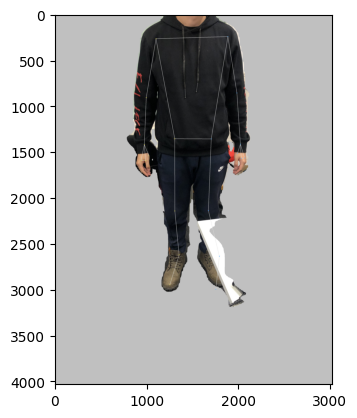

In [12]:
# Run Mediapipe skeleton detection for a single image

BG_COLOR = (192, 192, 192) # gray

with mp_pose.Pose(
    static_image_mode=True,
    model_complexity=2,
    enable_segmentation=True,
    min_detection_confidence=0.5) as pose:
    
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    image_height, image_width, _ = image.shape
    # Convert the BGR image to RGB before processing.
    results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    if not results.pose_landmarks:
        continue
    print(
        f'Nose coordinates: ('
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].x * image_width}, '
        f'{results.pose_landmarks.landmark[mp_pose.PoseLandmark.NOSE].y * image_height})'
    )

    annotated_image = image.copy()
    annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
    # Draw segmentation on the image.
    # To improve segmentation around boundaries, consider applying a joint
    # bilateral filter to "results.segmentation_mask" with "image".
    condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.1
    bg_image = np.zeros(image.shape, dtype=np.uint8)
    bg_image[:] = BG_COLOR
    annotated_image = np.where(condition, annotated_image, bg_image)
    # Draw pose landmarks on the image.
    mp_drawing.draw_landmarks(
        annotated_image,
        results.pose_landmarks,
        mp_pose.POSE_CONNECTIONS,
        landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
    
plt.imshow(annotated_image)

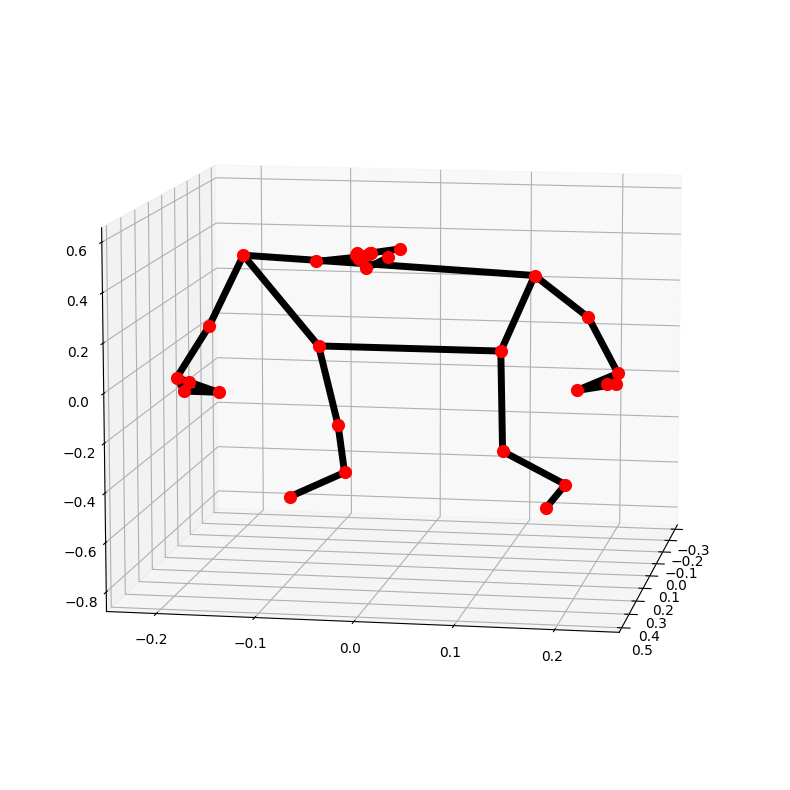

In [13]:
# Plot pose 3D skeleton detection landmark
mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

In [14]:
# Run Mediapipe skeleton detection for webcam input


cap = cv2.VideoCapture(0)

with mp_pose.Pose(
    # model_complexity=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5) as pose:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue

        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = pose.process(image)

        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        # Flip the image horizontally for a selfie-view display.
        cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
        if cv2.waitKey(5) & 0xFF == ord('q'):
            break
    
cap.release()
cv2.destroyAllWindows()

## 3 Parametric Hand Models

### 3.1 MANO Hand Model

The MANO [3] hand model is a parametric model that is learned from a dataset of different hand scans with different shapes and poses.

The benefit of the model is that the relationship between the joint locations and the skinned vertex locations is a linear function, yet it does not have the visual artifacts that a simple linear blend skinning has.

The parameters could be split into 3 types
1. Wrist translation $\in R^3$, describes the locaiton of the wrist (the root of the hand)
2. Pose Coeffecients $\theta \in R^{16 \times 3}$, an axisangle representaiton of the rotations for each of the joints (execluding the finger tips). Another representation that is used for the pose is the PCA coeffecients learned from the different hand poses in the dataset.
3. Shape Coeffecients $\beta \in R^{10}$, the PCA coeffecients of the hand shape, learned the different hand scans in the dataset (independent from the hand pose).

In [15]:
# download the mano weights
!pip uninstall -y manopth
!rm -fr manopth/
# follow the instruction for installation https://github.com/hassony2/manopth
!git clone https://github.com/hassony2/manopth.git
!ln -s '/home/marsil/common/mano_v1_2/models' 'manopth/mano/models'
%cd manopth/
!pip install -e . --force-reinstall
%cd ../


Found existing installation: manopth 0.0.1
Uninstalling manopth-0.0.1:
  Successfully uninstalled manopth-0.0.1
Cloning into 'manopth'...
remote: Enumerating objects: 144, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 144 (delta 43), reused 40 (delta 40), pack-reused 94
Receiving objects: 100% (144/144), 222.27 KiB | 6.95 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/home/marsil/git/notebooks/04-Mediapipe-Hand-and-Pose/Lecture/manopth
Obtaining file:///home/marsil/git/notebooks/04-Mediapipe-Hand-and-Pose/Lecture/manopth
  Preparing metadata (setup.py) ... done
  Running setup.py develop for manopth
You should consider upgrading via the '/home/marsil/git/notebooks/venv/bin/python3 -m pip install --upgrade pip' command.
/home/marsil/git/notebooks/04-Mediapipe-Hand-and-Pose/Lecture


/home/marsil/git/notebooks/04-Mediapipe-Hand-and-Pose/Lecture/manopth/manopth/manolayer.py:72: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:172.)
  torch.Tensor(smpl_data['betas'].r).unsqueeze(0))


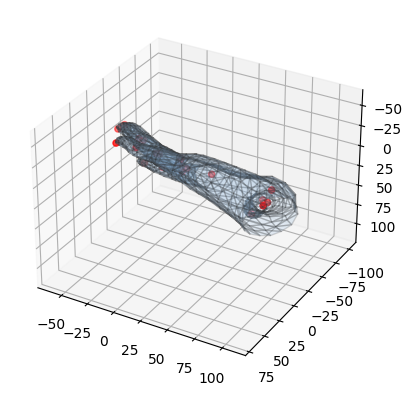

In [16]:
%matplotlib inline

import torch
import sys
from manopth.manolayer import ManoLayer
from manopth import demo


batch_size = 10
# Select number of principal components for pose space
ncomps = 6

# Initialize MANO layer
mano_layer = ManoLayer(mano_root='manopth/mano/models', use_pca=True, ncomps=ncomps)

# Generate random shape parameters
random_shape = torch.rand(batch_size, 10)
# Generate random pose parameters, including 3 values for global axis-angle rotation
random_pose = torch.rand(batch_size, ncomps + 3)

# Forward pass through MANO layer
hand_verts, hand_joints = mano_layer(random_pose, random_shape)
demo.display_hand({'verts': hand_verts, 'joints': hand_joints}, mano_faces=mano_layer.th_faces)

plt.show()

### 3.2 Interactive Demo
Try to perturb different shape/pose parameters. Switch `USE_PCA` to True and then try again, with the pose parameters.

<IPython.core.display.Javascript object>


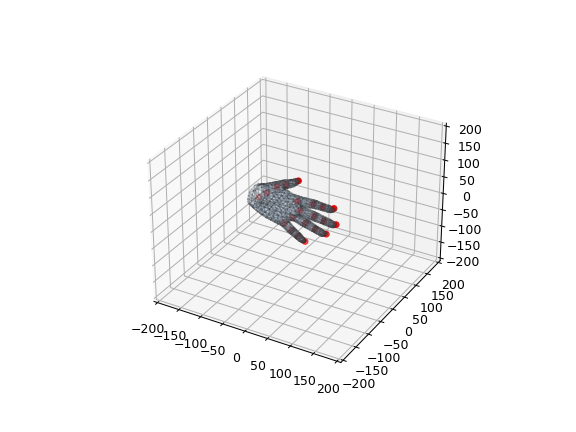

interactive(children=(FloatSlider(value=0.0, description='coeff_0', max=10.0, min=-10.0), FloatSlider(value=0.…

In [17]:
# Please run this example in jupyter notebook instead if jupyer lab because the later does not support interactive plotting mode, otherwise you could still use lab but change %matplotlib notebook to %matplotlib inline
#source https://www.pythonfixing.com/2022/03/fixed-javascript-error-ipython-is-not.html
%matplotlib inline
%matplotlib notebook

import numpy as np
from ipywidgets import *
from manopth.manolayer import ManoLayer
import matplotlib.pyplot as plt
import torch
from manopth import demo

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
# ax.title = 'Interactive Mano Demo'
ax.set_title('Interactive Mano Demo')

JOINT_NAMES = [
    'wrist',
    'index1',
    'index2',
    'index3',
    'middle1',
    'middle2',
    'middle3',
    'pinky1',
    'pinky2',
    'pinky3',
    'ring1',
    'ring2',
    'ring3',
    'thumb1',
    'thumb2',
    'thumb3',    
]

## Important Variables
USE_PCA = True # 'False'
NCOMPS = 6 # 48
SIDE = 'left' # 'right'
USE_EULER_INSTEAD_OF_AXISANGLE = True 

kwargs = {}
widget_kwargs = {}





if USE_PCA:
    for i in range(NCOMPS):
        k = f"coeff_{i}"
        kwargs[k] = 0.0
        widget_kwargs[k] = FloatSlider(value=0.0, min=-10, max=+10)

else:
    for i in range(21-5): # 21 joints - 5 finger tips
        for c in 'xyz':
            k = f"{JOINT_NAMES[i]}_{c}"
            kwargs[k] = 0.0
            lim = 90 if USE_EULER_INSTEAD_OF_AXISANGLE else 10
            widget_kwargs[k] = FloatSlider(value=0,min=-lim, max=+lim, disabeled=False, description=f"{JOINT_NAMES[i]}.{c}")

for i in range(10):
    k = f"B{i}"
    kwargs[k] = 0
    widget_kwargs[k] = FloatSlider(value=0, min=-10, max=+10, description=k)
                

kwargs['wrist_x'] =0.0
kwargs['wrist_y'] =0.0
kwargs['wrist_z'] =0.0

widget_kwargs['wrist_x'] =FloatSlider(value=0, min=-100,max=100)
widget_kwargs['wrist_y'] =FloatSlider(value=0, min=-100,max=100)
widget_kwargs['wrist_z'] =FloatSlider(value=0, min=-100,max=100)
        
def update_mano(**kwargs):
    model = ManoLayer(mano_root='manopth/mano/models', side=SIDE, use_pca=USE_PCA, ncomps=NCOMPS)
    wrist_translation = torch.Tensor([[kwargs['wrist_x'], kwargs['wrist_y'], kwargs['wrist_z']]])/1000
    shape_params = torch.Tensor([[kwargs[f"B{i}"] for i in range(10)]])
    pose_params = torch.zeros((1,48))
    if USE_PCA:
        for i in range(NCOMPS):
            k = f"coeff_{i}"
            pose_params[0,i] = kwargs[k]
    else:
        pose_params = torch.zeros((1,48))
        j = 0
        for i in range(21-5): # 21 joints - 5 finger tips
            vec = []
            for c in 'xyz':
                k = f"{JOINT_NAMES[i]}_{c}"
                pose_params[0,j] = kwargs[k]
                vec.append(kwargs[k])
                j += 1
            if USE_EULER_INSTEAD_OF_AXISANGLE:
                from scipy.spatial.transform.rotation import Rotation
                rotvec = Rotation.from_euler('xyz', vec, degrees=True).as_rotvec()
                pose_params[0,i*3: i*3+3] = torch.Tensor(rotvec)
    
    print(USE_PCA, pose_params.shape)   
    vertices, joints = model(th_pose_coeffs=pose_params, th_betas=shape_params, th_trans=wrist_translation)
    ax.clear()
    demo.display_hand({'verts': vertices,'joints': joints}, mano_faces=model.th_faces, ax=ax)
    ax.set_xlim3d([-200,200])
    ax.set_ylim3d([-200,200])
    ax.set_zlim3d([-200,200])

    
interact(update_mano, **widget_kwargs);

## Connecting Mediapipe and MANO

Check the script `hand_tracker.py` with in this week material folder (NS4).

## References

[1]. https://google.github.io/mediapipe/

[2]. https://google.github.io/mediapipe/solutions/hands.html

[3]. https://mano.is.tue.mpg.de/

[4]. https://github.com/hassony2/manopth